# Caulsal Inference on Marital_Status and Total Purchased

In [1]:
import pandas as pd
import numpy as np
from causalml.inference.meta import LRSRegressor, XGBTRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import shap

ModuleNotFoundError: No module named 'causalml'

In [2]:
data_newfeature=pd.read_csv('Clustered_Customer_Sales_Data.csv')

In [57]:
# All Puechases as Target
data_newfeature['Allpurchases'] = data_newfeature['NumDealsPurchases'] + data_newfeature['NumWebPurchases'] + data_newfeature['NumCatalogPurchases'] + data_newfeature['NumStorePurchases']


#  treatment
data_newfeature['treatment'] = data_newfeature['Marital_Status_Married']

# control
control_columns = [
    'Marital_Status_Alone', 'Marital_Status_Divorced', 'Marital_Status_Single',
    'Education_Master','Marital_Status_Widow', 'Marital_Status_YOLO',
    'Age', 'Income', 'Total_Children', 'Is_Parent', 'Member_Year', 'Family_Size',
    'Education_Basic', 'Education_Graduation', 'Marital_Status_Together', 'Education_PhD'
]


X = data_newfeature[control_columns]
y = data_newfeature['Allpurchases']
treatment_binary = data_newfeature['treatment']

# train and test
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, y, treatment_binary, test_size=0.2, random_state=42)

# Model
lr_model = LRSRegressor()
xgb_model = XGBTRegressor()

# Train
lr_model.fit(X_train, treatment_train, y_train)
xgb_model.fit(X_train, treatment_train, y_train)

# estimate
predictions_lr = lr_model.predict(X_test)
predictions_xgb = xgb_model.predict(X_test)

# RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, predictions_lr))
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))

print(f"LR Model RMSE: {rmse_lr}")
print(f"XGB Model RMSE: {rmse_xgb}")

# cross validation ATE
def cross_validate_ate(estimator, X, treatment, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    ate_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        treatment_train, treatment_test = treatment.iloc[train_index], treatment.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, treatment_train, y_train)
        ate_estimate = estimator.estimate_ate(X_test, treatment_test, y_test)[0]
        ate_scores.append(ate_estimate)

    return np.mean(ate_scores), np.std(ate_scores)

# LRSRegressor ATE
ate_mean, ate_std = cross_validate_ate(lr_model, X, treatment_binary, y, cv=5)
print(f"LRSRegressor ATE: {ate_mean} (±{ate_std})")

# XGBTRegressor ATE
ate_mean, ate_std = cross_validate_ate(xgb_model, X, treatment_binary, y, cv=5)
print(f"XGBTRegressor ATE: {ate_mean} (±{ate_std})")



LR Model RMSE: 17.64057173450345
XGB Model RMSE: 17.583699964162527
LRSRegressor ATE: 0.958410784613999 (±0.5816509227489313)
XGBTRegressor ATE: 0.15496349611452648 (±0.4265202042288234)


The results indicate that both the Linear Regression Surrogate (LRS) model and the eXtreme Gradient Boosting Treatment (XGBT) model have similar predictive accuracy, with RMSE values of approximately 17.64 and 17.58, respectively. This suggests that both models are equally effective in predicting the total number of purchases (`Allpurchases`) based on the given control variables.

The Average Treatment Effect (ATE) estimated by the LRSRegressor is 0.9584 with a standard deviation of ±0.5817, suggesting a positive but somewhat uncertain impact of being married (`Marital_Status_Married`) on the total purchases. The larger standard deviation indicates a higher level of uncertainty in this estimate.

On the other hand, the XGBTRegressor's ATE estimate is 0.1549 with a standard deviation of ±0.4265, indicating a smaller and also uncertain impact of marital status on purchasing behavior. The smaller ATE value suggests that, according to the XGBT model, being married has a less significant effect on the total number of purchases compared to the LRS model's estimation.

In summary, both models suggest that being married (`Marital_Status_Married`) has a positive effect on the total number of purchases, with the LRS model indicating a more pronounced effect. However, the presence of substantial standard deviations in both ATE estimates highlights the variability and uncertainty surrounding these effects. This suggests that while marital status may influence purchasing behavior, other factors represented by the control variables also play a significant role, and the exact impact of marital status varies across different observations.

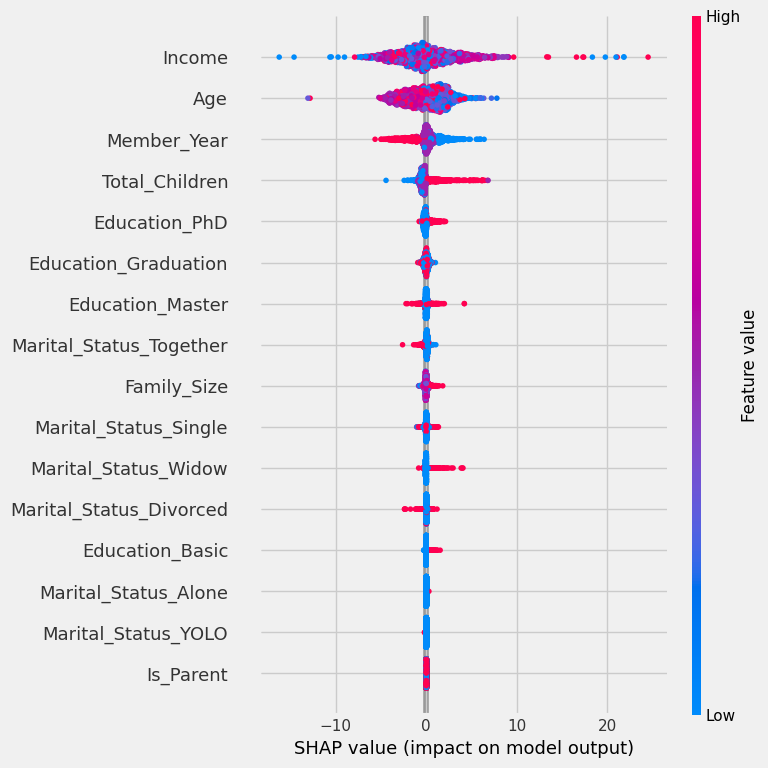

In [58]:
# SHAP
tau_pred = xgb_model.predict(X_train)
xgb = XGBRegressor().fit(X_train, tau_pred)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

# SHAP plot
shap.summary_plot(shap_values, X_train)